In [6]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re 
from collections import Counter
from string import punctuation

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import load_iris

# DistilBERT/Tensorflow/Torch
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping


lemma = WordNetLemmatizer()

Genauere Installation zu Transformers(DistilBERT): https://huggingface.co/docs/transformers/installation

Hab es jetzt ohne Virtual Environment gemacht, wie dort beschrieben, mal schauen

In [13]:
# Pandas Progress bar
tqdm.pandas()

In [14]:
df = pd.read_csv('../Datasets/Books_rating.csv')

In [15]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [16]:
df[['helpful_0', 'helpful_1']] = df['review/helpfulness'].str.split('/', expand=True)

# Konvertieren der 'helpfulness'-Spalte in numerische Werte (falls notwendig)
#df['review/helpfulness'] = pd.to_numeric(df['review/helpfulness'], errors='coerce')

df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,helpful_0,helpful_1
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,7,7
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,10,10
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",10,11
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",7,7
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,3,3


In [17]:
# Daten vor dem Plotten sortieren/konvertieren
df['helpful_0'] = df['helpful_0'].progress_apply(pd.to_numeric)
df['helpful_1'] = df['helpful_1'].progress_apply(pd.to_numeric)

100%|██████████| 3000000/3000000 [00:43<00:00, 68781.72it/s]


In [18]:
df['helpful_0'] = df['helpful_0'].astype(int)
df['helpful_1'] = df['helpful_1'].astype(int)

In [19]:
# Hab den Plot mal weggelassen

In [20]:
num_rows = len(df[df['helpful_1'] >= 20])
print("Number of rows with helpful_1 > 3: ", num_rows)

Number of rows with helpful_1 > 3:  239553


In [21]:
# Remove reviews with not enough helpful votes
df = df[df['helpful_1'] >= 20]

In [22]:
df['helpful_ratio'] = df['helpful_0'] / df['helpful_1']

In [23]:
df['ratio_percent'] = (df['helpful_ratio'] * 100).astype(int)
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,helpful_0,helpful_1,helpful_ratio,ratio_percent
47,0802841899,The Church of Christ: A Biblical Ecclesiology ...,25.97,ARI272XF8TOL4,Christopher J. Bray,74/81,5.0,955411200,Ecclesiological Milestone,With the publication of Everett Ferguson's boo...,74,81,0.913580,91
81,0974289108,The Ultimate Guide to Law School Admission: In...,14.95,A1KZ0RDJZQSY4O,sayock,27/29,3.0,1090368000,No &quot;Insider&quot; Secrets,If you are someone who is fairly new to the la...,27,29,0.931034,93
88,0809080699,The Repeal of Reticence: A History of America'...,NaN,A18YY5TBNSDW3O,Bartleby,29/29,5.0,899164800,Great treatment of the defeat of reticence by ...,"Using a quiet, restrained writing style that i...",29,29,1.000000,100
91,B000NKGYMK,Alaska Sourdough,NaN,NaN,NaN,36/37,5.0,949104000,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,0.972973,97
92,B000NKGYMK,Alaska Sourdough,NaN,AC58Z72OB2DDX,Gary W. Marian,29/30,5.0,945734400,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,0.966667,96


In [24]:
# Drop unused columns
df.drop(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/time', 'review/summary'], axis='columns', inplace=True)

In [25]:
df = df.rename(columns={"review/text":"Review","review/score": "Rating"})

df['review_len'] = [len(text.split()) for text in df.Review]

In [26]:
len(df)

239553

In [27]:
df = df[df['review_len'] <= 300]

In [28]:
len(df)

181104

In [29]:
def convert_label(df) : 
    if df['ratio_percent'] <= 70 : 
        rate = 0 # for Negative 
    else : 
        rate = 1 # for Positive
        
    return rate

In [30]:
df['IsHelpful'] = df.apply(convert_label, axis = 1)
df.head()

,review/helpfulness,Rating,Review,helpful_0,helpful_1,helpful_ratio,ratio_percent,review_len,IsHelpful
91,36/37,5.0,Ruth Allman has written an excellent book abou...,36,37,0.972973,97,153,1
92,29/30,5.0,"I have been using this book since 1988, the ei...",29,30,0.966667,96,63,1
93,25/28,5.0,"My poor dogeared, stained copy of this book ca...",25,28,0.892857,89,206,1
127,3/20,1.0,This book in my opinion is biased and takes an...,3,20,0.150000,15,92,0
139,20/20,5.0,If you're already a fan of the Eyewitness Trav...,20,20,1.000000,100,234,1


### Data Prepossessing :ghost:

In [31]:
# OLD DataPrep
def DataPrep(text) : 
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if not word in stop_words]
    
    # lemmatization 
    words = [lemma.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

ChatGPT hat bei Preprocessing nichts anderes außer Tokenizing erwähnt, mal schauen wie das läuft

In [32]:
# Tokenize the reviews using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X = tokenizer(df['Review'].tolist(), padding=True, truncation=True, max_length=512, return_tensors='tf')

In [33]:
# Convert labels to numpy array
y = df['IsHelpful'].values

# Convert input_ids to numpy array
X_ids = np.array(X['input_ids'].numpy())

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ids, y, test_size=0.2, random_state=42)

In [35]:
# Build the DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [36]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=5e-5), 
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=[SparseCategoricalAccuracy('accuracy')])

## Das hatte bei mir ein ETA von 23 Stunden, letsgoo

Ich habs das jetzt gerade mal in nem Google Colab laufen nebenbei (Da warens nur ca.3 pro Epoche)

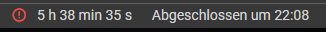

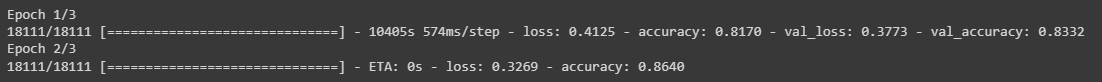

Weiter gings leider nicht bevor es abgebrochen ist aufgrund von Google Colab beschränkungen, aber zumindest 2/3 Epochen basically

In [2]:
# Train the model
#history = model.fit(X_train, y_train, 
                    #validation_data=(X_test, y_test), 
                    #epochs=3, 
                    #batch_size=32, 
                    #callbacks=[EarlyStopping(patience=2)])